<a href="https://colab.research.google.com/github/MTxSouza/Employeers/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [51]:
!kaggle datasets download -d tawfikelmetwally/employee-dataset
!unzip employee-dataset.zip -d dataset/
!rm -rf employee-dataset.zip
!mv dataset/Employee.csv dataset/dataset.csv

  0% 0.00/18.5k [00:00<?, ?B/s]
100% 18.5k/18.5k [00:00<00:00, 37.9MB/s]
Archive:  employee-dataset.zip
replace dataset/Employee.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/Employee.csv    


# Notebook setup

### Imports

In [455]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
import scipy.stats as ss
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Utils

In [188]:
def cramers_v_corr(col1: pd.Series, col2: pd.Series) -> float:
    confusion_matrix = pd.crosstab(col1,col2)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def categorical_corr(data: pd.DataFrame) -> tuple:
    mtx_dim = data.shape[1]
    corr_mtx = np.zeros(shape=(mtx_dim, mtx_dim), dtype=np.float32)

    for col, row in product(range(mtx_dim), range(mtx_dim)):
        corr_mtx[col,row] = cramers_v_corr(col1=data.iloc[:,col], col2=data.iloc[:,row])

    return corr_mtx, data.columns

# Analysis

In [542]:
df = pd.read_csv('dataset/dataset.csv')
# Apply this method to under sampling
# the dataset to balance the target
# column
BALANCE = True

if BALANCE:
    undersample = RandomUnderSampler(sampling_strategy='majority')
    x, y = df.drop(labels='LeaveOrNot', axis=1), df['LeaveOrNot']
    ux, uy = undersample.fit_resample(x, y)
    df = pd.concat(objs=[ux, uy], axis=1)
    del x, y, ux, uy

In [543]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2013,Bangalore,3,26,Male,No,4,0
1,Bachelors,2016,Pune,3,24,Male,No,2,0
2,Bachelors,2016,Bangalore,3,27,Male,No,5,0
3,Bachelors,2015,Bangalore,3,39,Female,No,0,0
4,Bachelors,2015,Pune,3,29,Male,No,0,0


In [544]:
# Checking type of columns and
# if there is any Null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  3200 non-null   object
 1   JoiningYear                3200 non-null   int64 
 2   City                       3200 non-null   object
 3   PaymentTier                3200 non-null   int64 
 4   Age                        3200 non-null   int64 
 5   Gender                     3200 non-null   object
 6   EverBenched                3200 non-null   object
 7   ExperienceInCurrentDomain  3200 non-null   int64 
 8   LeaveOrNot                 3200 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 225.1+ KB


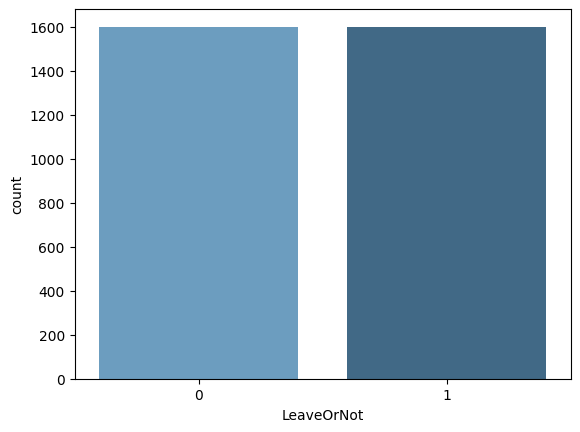

In [545]:
# Checking distribution of target
# column
sns.countplot(data=df, x='LeaveOrNot', palette='Blues_d')
plt.show()

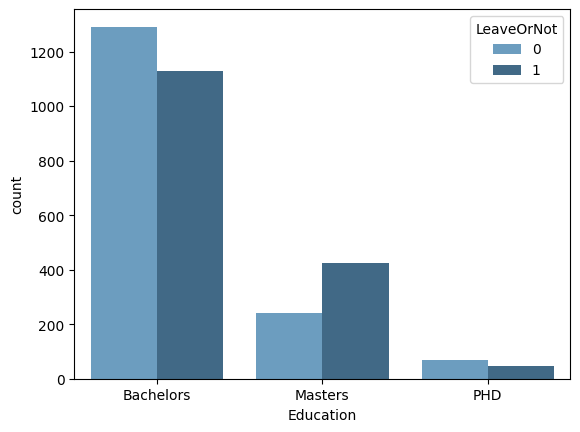

In [546]:
# Checking `Education` variable
sns.countplot(data=df, x='Education', hue='LeaveOrNot', palette='Blues_d')
plt.show()
# -----------------------------------------------
# BALANCE = False
# There is no relation about the escolarity of
# employeer that justify the reason of it leaves
# -----------------------------------------------
# BALANCE = True
# People with Master degree has more probability
# to leave than others, it shows that almost
# more than half of masters leave it positions
# in company

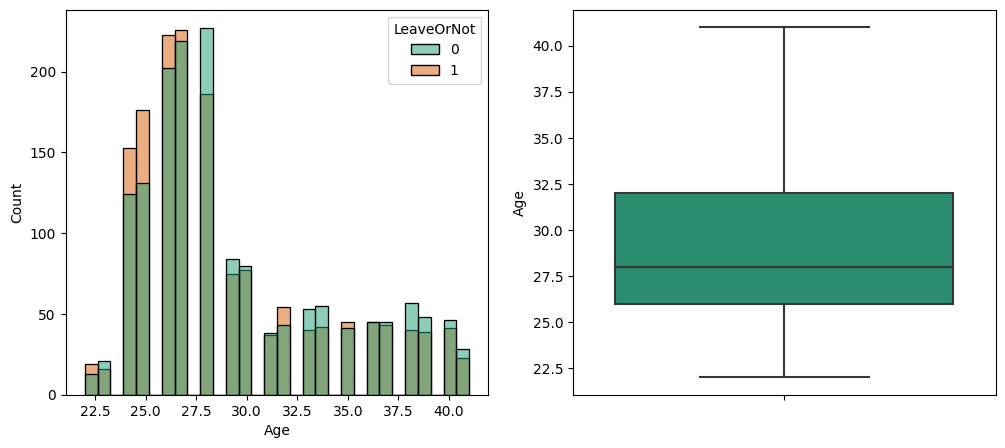

In [547]:
# Checking the age of people that
# leaves more frequently
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.histplot(data=df, x='Age', hue='LeaveOrNot', palette='Dark2', bins=30, ax=ax[0])
sns.boxplot(data=df, y='Age', palette='Dark2', ax=ax[1])
plt.show()
# -----------------------------------------------
# BALANCE = False
# I can see that people tends to leaves more when
# they are young, between 24 and 28 years old.
# My guest is that, people join the companies younger
# (20 to 23 years old) to get their first experience,
# and then leaves to get other oportunities in carieer
# -----------------------------------------------
# BALANCE = True
# I can see that people tends to leaves more when
# they are young, between 24 and 27 years old, and
# tends to stay when they become olders.

In [548]:
# computing correlation between `ExperienceInCurrentDomain`,
# `PaymentTier` and `LeaveOrNot` columns | Cramér's V Correlation
cat_corr, name_corr = categorical_corr(data=df[['ExperienceInCurrentDomain', 'PaymentTier', 'LeaveOrNot']])

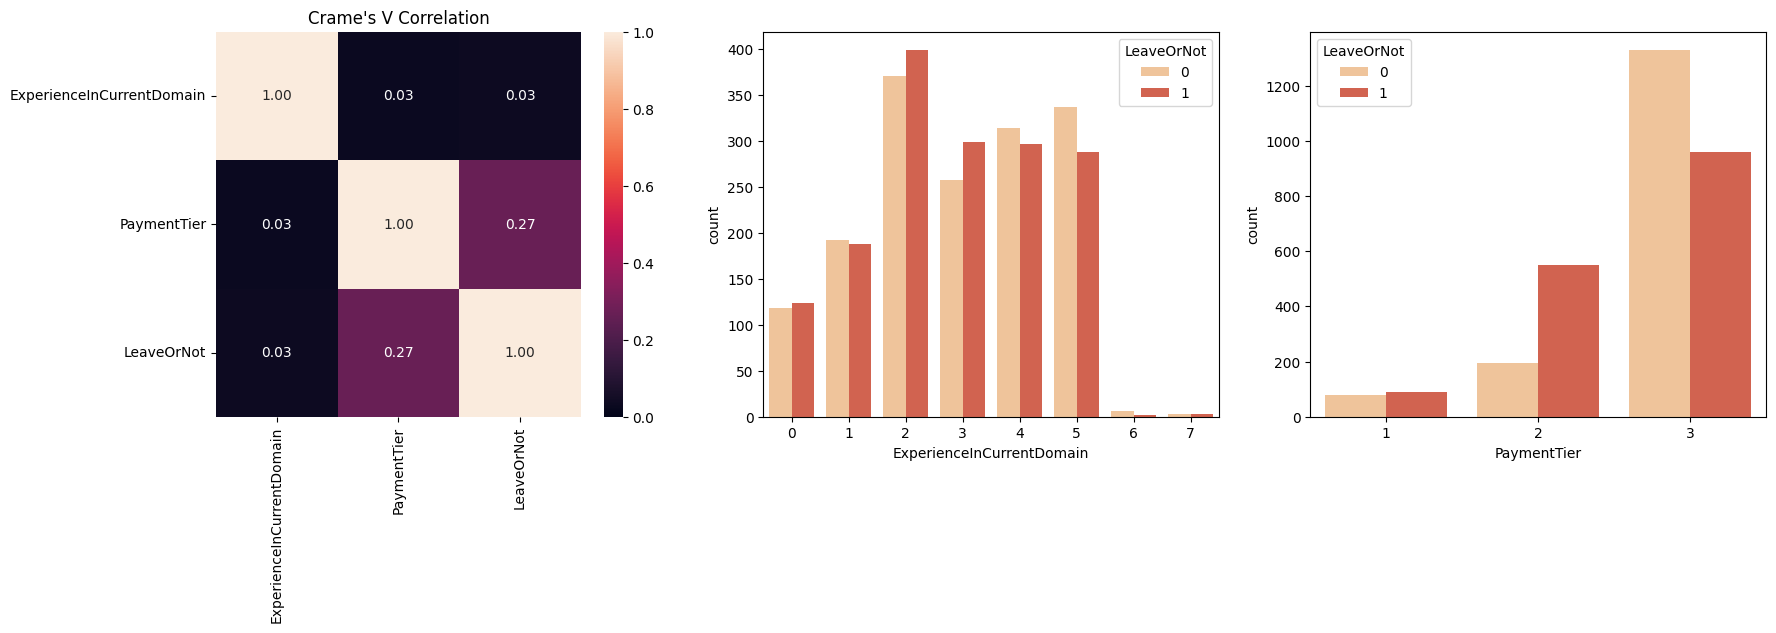

In [549]:
# Checking the number of exxperience of
# people that leaves the company
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].set_title(label="Crame's V Correlation")
sns.heatmap(data=cat_corr, vmin=0, vmax=1, annot=True, fmt='.2f', xticklabels=name_corr, yticklabels=name_corr, ax=ax[0])

sns.countplot(data=df, x='ExperienceInCurrentDomain', hue='LeaveOrNot', palette='OrRd', ax=ax[1])
sns.countplot(data=df, x='PaymentTier', hue='LeaveOrNot', palette='OrRd', ax=ax[2])
plt.show()
# -----------------------------------------------
# BALANCE = False
# I can see that people with at least 2
# years of experience in area tends to leave
# more. So imagining the people wants to get
# a few years of experience in area and leave
# to get better oportunities, this graph follows
# a bit this idea.
# -----------------------------------------------
# BALANCE = True
# For some reason, people that has the 2º tier of
# salary leaves more often as well

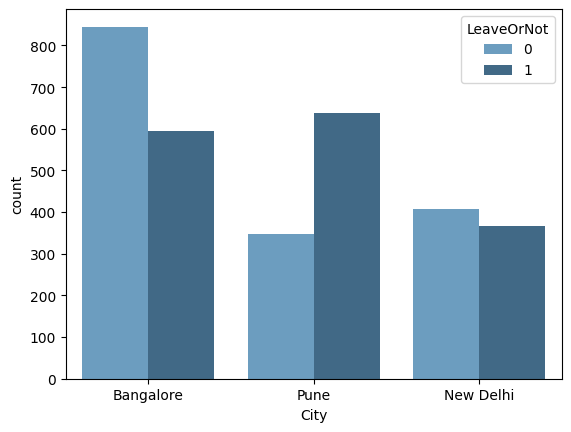

In [550]:
# Checking the cities that has the
# most employeers that leave the
# company
sns.countplot(data=df, x='City', hue='LeaveOrNot', palette='Blues_d')
plt.show()
# -----------------------------------------------
# BALANCE = False | True
# I can see that, for some reason, people that lives
# in Pune tends to leave the company more often than
# Bangalore and New Delhi. But why?

Pune city

In [551]:
df_pune = df[df['City'] == 'Pune'].copy()

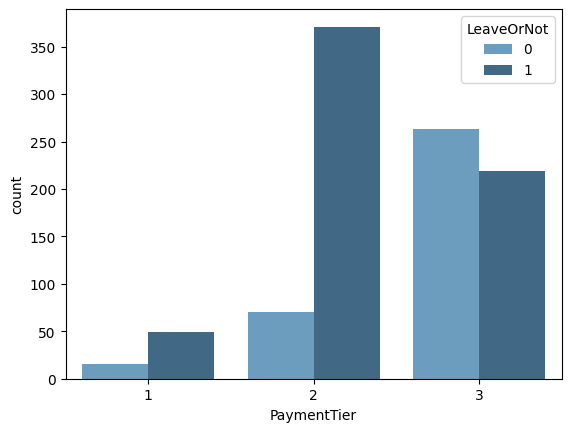

In [552]:
# Checking payment of Pune population
sns.countplot(data=df_pune, x='PaymentTier', hue='LeaveOrNot', palette='Blues_d')
plt.show()
# -----------------------------------------------
# BALANCE = False
# People that lives in Pune and has the 2º tier
# payment tends to leave more often than other.
# I'll check that this pattern appers in other cities
# -----------------------------------------------
# BALANCE = True
# People that lives in Pune and has the 1º and 2º
# payment tier tends to leave more often than other.
# I'll check that this pattern appers in other cities

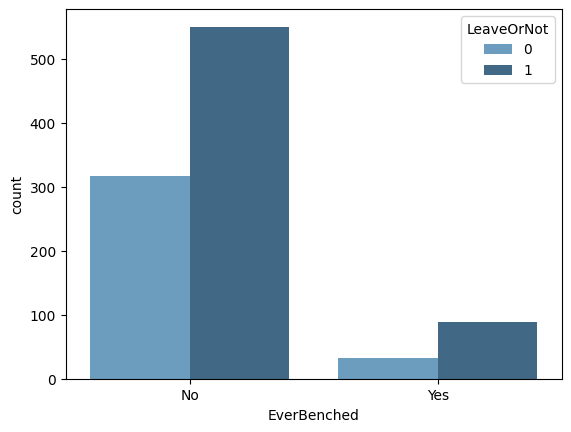

In [554]:
# Checking if the employeer has been temporality
# without a assigned word
sns.countplot(data=df_pune, x='EverBenched', hue='LeaveOrNot', palette='Blues_d')
plt.show()
# -----------------------------------------------
# BALANCE = False
# I can see that employeers that has been temporality
# without any assigned word tends to leave, whereas
# those that has been with a assigned word stayed in
# company
# -----------------------------------------------
# BALANCE = True
# In both cases, there is a high number of employeers
# that leaves the company, either it has been with a
# assigned word or not

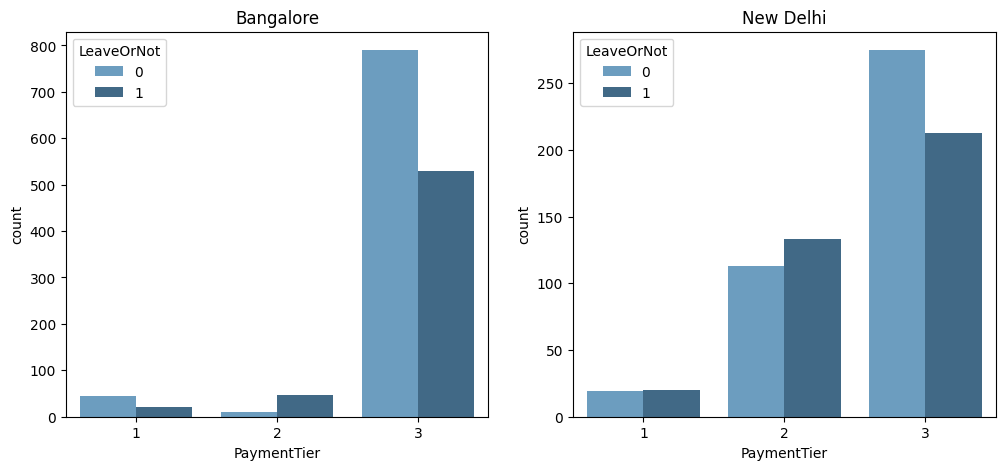

In [555]:
# Checking payment of Bangalore and
# New Delhi population
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].set_title(label='Bangalore')
sns.countplot(data=df[df['City'] == 'Bangalore'], x='PaymentTier', hue='LeaveOrNot', palette='Blues_d', ax=ax[0])

ax[1].set_title(label='New Delhi')
sns.countplot(data=df[df['City'] == 'New Delhi'], x='PaymentTier', hue='LeaveOrNot', palette='Blues_d', ax=ax[1])

plt.show()
# -----------------------------------------------
# BALANCE = False
# In Bangalore, this pattern appers a bit but it
# still more noticed in Pune
# -----------------------------------------------
# BALANCE = True
# The pattern showed above seens to be more visible
# in Pune than other cities

In [556]:
# Checking correlation between `Gender`
# and `LeaveOrNot` variable
cat_corr, name_corr = categorical_corr(data=df[['Gender', 'LeaveOrNot']])

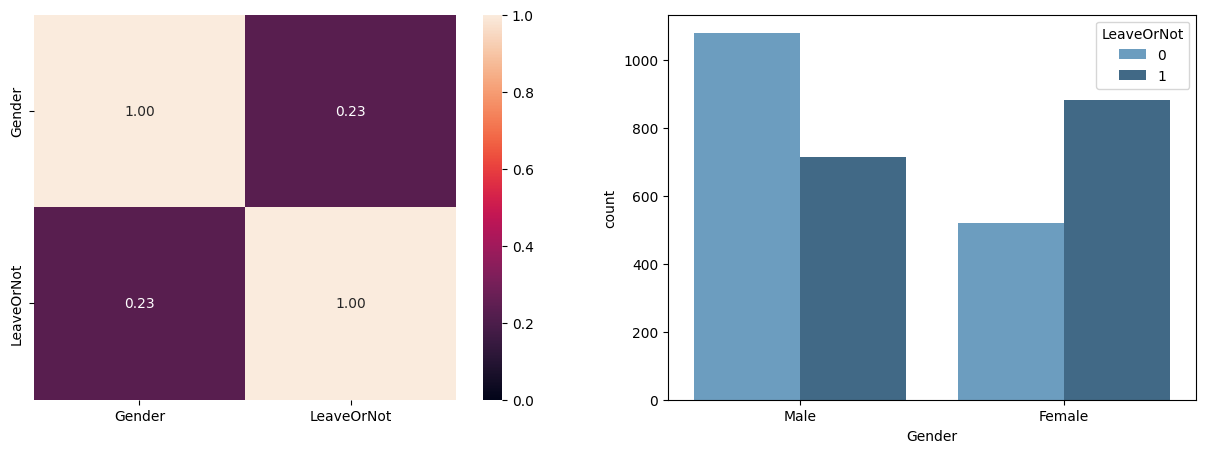

In [557]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.heatmap(data=cat_corr, vmin=0, vmax=1, annot=True, fmt='.2f', xticklabels=name_corr, yticklabels=name_corr, ax=ax[0])
sns.countplot(data=df, x='Gender', hue='LeaveOrNot', palette='Blues_d', ax=ax[1])

plt.show()
# -----------------------------------------------
# BALANCE = False
# Maybe the reason there is a small correlation is
# because there are more data of mans than womans,
# but I will consider it to my predicted model
# -----------------------------------------------
# BALANCE = True
# I can see that womans leaves more often than
# mans in general

# Model

In [558]:
# Selecting variables to train a model
features_col = ['City', 'Gender', 'Age', 'PaymentTier', 'Education', 'EverBenched', 'JoiningYear']
target_col = 'LeaveOrNot'

x, y = df[features_col].copy(), df[target_col].copy()

In [559]:
# Converting strings to number
city_map = {value: key for key, value in enumerate(x['City'].unique())}
gender_map = {value: key for key, value in enumerate(x['Gender'].unique())}
education_map = {value: key for key, value in enumerate(x['Education'].unique())}
bench_map = {value: key for key, value in enumerate(x['EverBenched'].unique())}
year_map = {value: key for key, value in enumerate(x['JoiningYear'].unique())}

x['City'] = x['City'].map(city_map)
x['Gender'] = x['Gender'].map(gender_map)
x['Education'] = x['Education'].map(education_map)
x['EverBenched'] = x['EverBenched'].map(bench_map)
x['JoiningYear'] = x['JoiningYear'].map(year_map)

display(x)

,City,Gender,Age,PaymentTier,Education,EverBenched,JoiningYear
0,0,0,26,3,0,0,0
1,1,0,24,3,0,0,1
2,0,0,27,3,0,0,1
3,0,1,39,3,0,0,2
4,1,0,29,3,0,0,2
...,...,...,...,...,...,...,...
3195,0,0,28,3,0,0,5
3196,0,1,33,1,0,0,1
3197,1,1,32,3,0,1,2
3198,1,0,37,2,1,0,0


In [560]:
# Splitting the data to train an
# algorithm to predict if a employeer
# could leave or not a company
xtrain, xval, ytrain, yval = train_test_split(x, y, random_state=1234, shuffle=True, train_size=0.8)

In [561]:
print(f'Train size:\n\t{xtrain.shape}\n\t{ytrain.shape}')
print(f'Valid size:\n\t{xval.shape}\n\t{yval.shape}')

Train size:
	(2560, 7)
	(2560,)
Valid size:
	(640, 7)
	(640,)


In [562]:
# Selecting a model
models = {
    'tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': np.arange(1, 40, 1),
            'criterion': ['gini', 'log_loss', 'entropy'],
            'max_leaf_nodes': np.arange(2, 40, 1)
        }
    },
    'neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'weights': ['uniform', 'distance'],
            'n_neighbors': np.arange(2, 50)
        }
    },
    'log': {
        'model': LogisticRegression(),
        'params': {}
    }
}

algorithm = 'neighbors'
model = models[algorithm]['model']
params = models[algorithm]['params']

In [563]:
# Creating Grid Search Algorithm to
# test multiple hyper-parameters
gs = GridSearchCV(model, params)

In [564]:
# Training
results = gs.fit(xtrain, ytrain)

In [565]:
results.best_estimator_

KNeighborsClassifier(n_neighbors=17)

In [566]:
# Validating
yhat = results.predict(xval)

In [567]:
# Creating a DataFrame results
df_results = pd.DataFrame(data={'y': yval, 'predict': yhat})

In [568]:
df_results.head(10)

,y,predict
219,0,0
1680,1,1
2800,1,0
2006,1,1
1612,1,1
1177,0,1
1155,0,0
2930,1,1
1400,0,0
1947,1,1


In [569]:
# Computing final score
score = accuracy_score(yval, yhat)

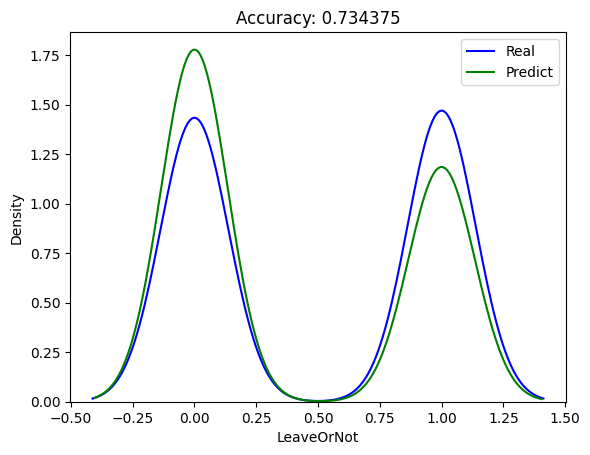

In [570]:
ax = sns.kdeplot(data=yval, color='b', label='Real')
sns.kdeplot(data=yhat, color='g', label='Predict', ax=ax)
plt.title(label=f'Accuracy: {score}')
plt.legend()
plt.show()